# Denmark

This notebook contains all the Julia 1.4 code required to
characterize the propagation of CoViD19 as discussed in the main
notebook: _Population_dynamics.ipynb_

### Initialization, display LOAD_PATH at the end

In [1]:
push!(LOAD_PATH, pwd())
if ispath( pwd()*"/src")
    push!(LOAD_PATH, pwd()*"/src")
end


using SpecialFunctions, LaTeXStrings
using DataFrames, Query, CSV, Dates
using LsqFit

using MyFunctions, Mrate

using Plots
theme(:solarized_light)

### Parametrization for the incubation times, source:
https://doi.org/10.2807/1560-7917.ES.2020.25.5.2000062

In [2]:
μΓ, σΓ = 6.5, 2.6       # mean and standard deviation for incubation

αΓ( μ, σ ) = μ^2/σ^2    # [α] = 1  is a dimensionless parameter
βΓ( μ, σ ) = μ / σ^2    # [β] = 1/T has dimension of frequency

α0 = αΓ( μΓ, σΓ )
β0 = βΓ( μΓ, σΓ )

ρ0=[α0,β0]

2-element Array{Float64,1}:
 6.249999999999999
 0.9615384615384615

### load data and manipulate data

In [3]:
dset_origin = "/data.europa.eu"
dset_name = "6u83xREK"
worlddata = CSV.File( pwd()*dset_origin*"/"*dset_name ) |> DataFrame!

country_name = "Denmark"
country = worlddata |> @filter(_.countriesAndTerritories==country_name
    ) |> DataFrame

dates = Date.( country[!,:dateRep], "d/m/y" )
population = country[1,:popData2018]

5797446

In [4]:
ordering = sortperm( dates );
dates_ordered = dates[ordering];
cases = country[!,:cases][ordering];
deaths = country[!,:deaths][ordering];

In [5]:
t_offset = dates_ordered[1];
Δt = dates_ordered -t_offset;
Δtv = Dates.value.( Δt );

In [6]:
cases_cum =  cumsum( cases );
deaths_cum =  cumsum( deaths );
n_cases = cases_cum/population;
n_deaths = deaths_cum/population;

ndata = n_cases;

#### visualize raw data

In [7]:
nM = 1.25 *maximum( ndata );
nm = 0.75 *minimum( ndata );

tm, tM = 1, maximum( Δtv ) +5;

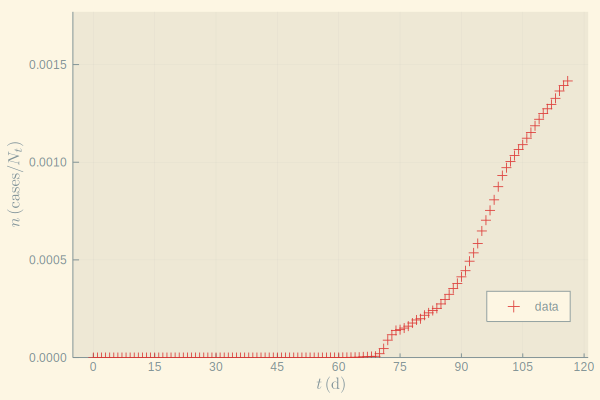

In [8]:
plot( Δtv, ndata, label="data"
    , markershape=:+, markersize=5, linealpha=0
    , legend=:bottomright )
plot!( xlabel = L"t \, \mathrm{(d)}",
    xlims = (-5,tM), xticks = 0:15:tM )
plot!( ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (nm,nM)  )

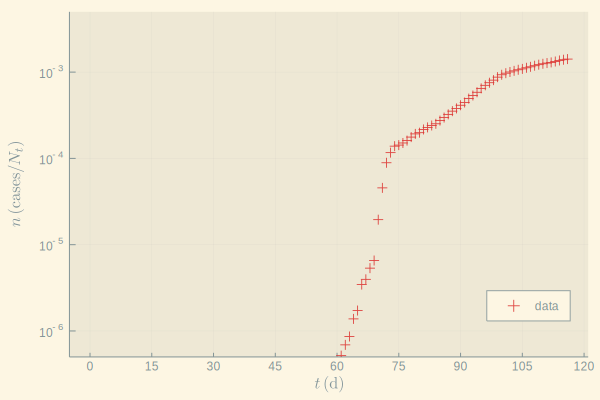

In [9]:
savefig("img/"*country_name*"_raw.svg")
plot!( yscale = :log10, ylims = (5*10^(-7.), 5*10^(-3.)) )

In [10]:
savefig("img/"*country_name*"_raw_log.svg")
plot!( yscale = :auto, ylims = (nm,nM) );

### The models
__Note:__ parameter p[2] is not multiplied by p[1] as in the main notes. Here p[2] is dimensionless! To recover the definition used in the main text divide by p[1], ie t_0 = p[2]/p[1]

In [11]:
# simple logistic model
@. model0(t,p) = 1/( 1.0 +exp( -p[1]*t +p[2] ) )

model0 (generic function with 1 method)

In [12]:
# the m-steady state model and its Jacobian
# definitions of modelm, modelm_j and all other relevant functions
# at Mrate.jl and MyFunctions.jl

function m_m( t, p )
    modelm(t,p,ρ0)
end

function j_m(t::Array,p)
    J = Array{Float64}(undef, length(t), length(p))
    J = modelm_j(t, p, ρ0)
end

j_m (generic function with 1 method)

In [13]:
p0 = [0.25, 0. ];
x0 = [0, 1.0, 2.0];
@time model0(0.0, p0);
@time model0(x0, p0);
@time m_m(0.0,p0);
@time m_m(x0,p0);
@time j_m(x0,p0);

p2 = [0.25, 18.8, 0.0025, 45., 0.035, 65. ];
@time m_m(0.0,p2);
@time m_m(x0,p2);
@time j_m(x0,p2);

  0.096422 seconds (206.31 k allocations: 11.586 MiB, 20.05% gc time)
  0.173222 seconds (613.69 k allocations: 30.871 MiB)
  0.500346 seconds (656.32 k allocations: 34.481 MiB, 3.95% gc time)
  0.105886 seconds (239.78 k allocations: 12.636 MiB)
  2.477215 seconds (4.71 M allocations: 256.072 MiB, 4.05% gc time)
  0.000008 seconds (2 allocations: 32 bytes)
  0.000009 seconds (1 allocation: 112 bytes)
  0.000015 seconds (32 allocations: 3.719 KiB)


### Nonlinear fits
#### The logistic fit

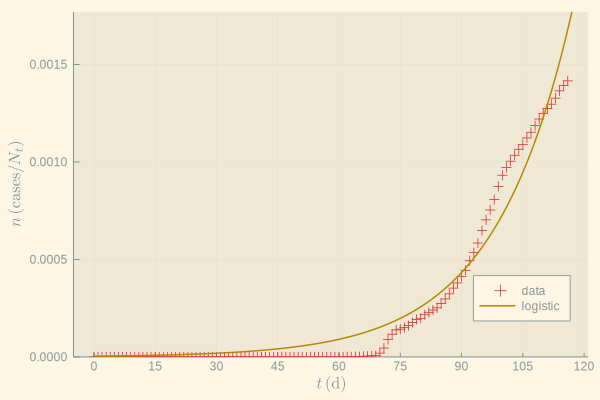

In [14]:
dm, dM = 1, length(Δtv)
fit0 = curve_fit( model0, Δtv[dm:dM], ndata[dm:dM], p0 )

tcont = range(Δtv[1],Δtv[end]*1.1; length=length(Δtv))
estimate0 = model0( tcont, fit0.param )
plot!( tcont, estimate0, label="logistic", linewidth=1.5 )

In [15]:
savefig("img/"*country_name*"_logistic.svg")


# truncate the dataset
dm, dM = 1, 72
p0 = [1., 80]

fit0b = curve_fit( m_m, j_m, Δtv[dm:dM], ndata[dm:dM], p0 )
estimate0b = m_m( tcont, fit0b.param );

dm, dM = 75, 92
p0 = [1., 80]

fit0c = curve_fit( m_m, j_m, Δtv[dm:dM], ndata[dm:dM], p0 )
estimate0c = m_m( tcont, fit0c.param );

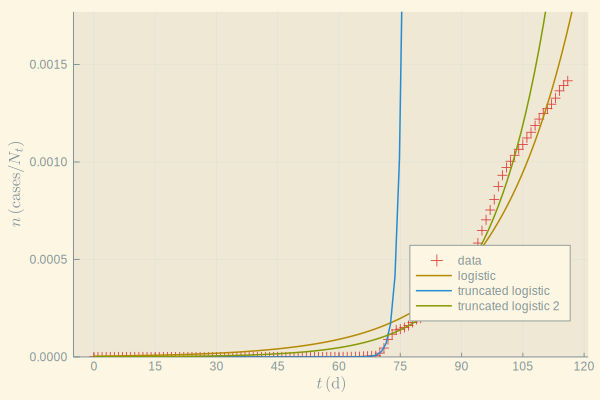

In [16]:
pstr = "truncated logistic"
plot!( tcont, estimate0b, label=pstr, linewidth = 1.5 )
pstr = "truncated logistic 2"
plot!( tcont, estimate0c, label=pstr, linewidth = 1.5 )

In [17]:
# half-population date!
t12 = floor( fit0b.param[2]/fit0b.param[1] )
t_offset +Dates.Day( t12 )

2020-03-23

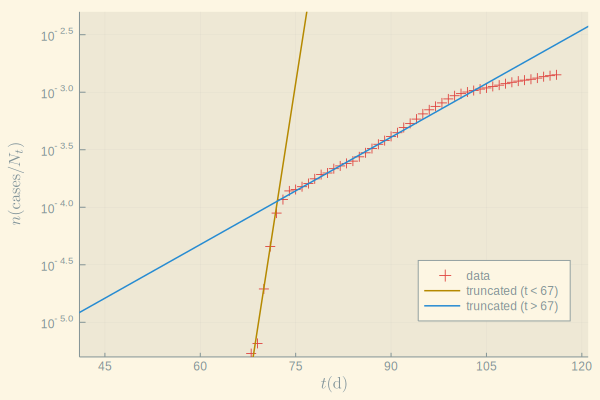

In [18]:
plot( Δtv, ndata, label="data"
    , markershape=:+, markersize=5, linealpha=0
    , legend=:bottomright )
plot!( xlabel = L"t \mathrm{(d)}",
    xlims = (41,tM), xticks = 45:15:tM )
plot!( ylabel = L"n (\mathrm{cases}/N_t)", ylims = (nm,nM)  )
plot!( yscale = :log10, ylims = (5*10^(-6.),5*10^(-3.)) )
plot!( tcont, estimate0b, label="truncated (t < 67)", linewidth=1.5 )
plot!( tcont, estimate0c, label="truncated (t > 67)", linewidth=1.5 )

In [19]:
savefig("img/"*country_name*"_truncated_log.svg")
plot!( yscale = :none, ylims = (nm,nM)  );

#### two steady state model m=1

In [20]:
dm, dM = 1, length(Δtv)
p1 = [0.8, 15, 0.08, 60 ]
fit1 = curve_fit( m_m, j_m, Δtv[dm:dM], ndata[dm:dM], p1 )
estimate1 = m_m( tcont, fit1.param );

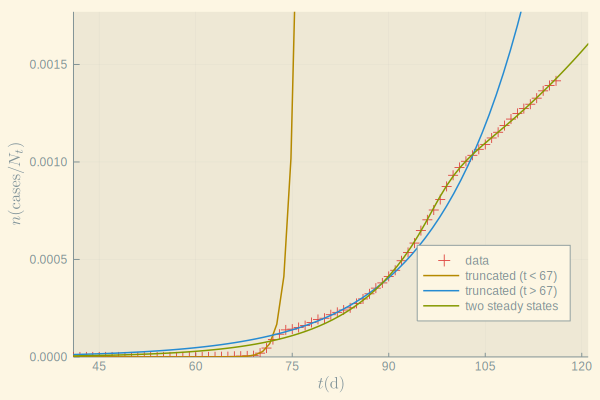

In [21]:
pstr = "two steady states"
plot!( tcont, estimate1, label=pstr, linewidth=1.5  )

In [22]:
# transition date (day)
t_offset +Dates.Day( floor( fit1.param[4] ) )

2020-04-02

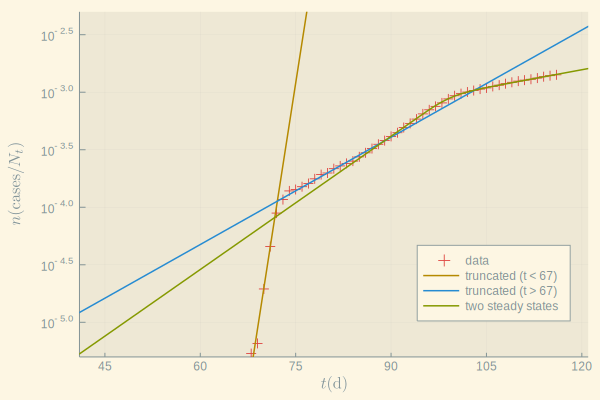

In [23]:
savefig("img/"*country_name*"_fits_converged.svg")

plot!( yscale = :log10, ylims = (5*10^(-6.), 5*10^(-3.)) )

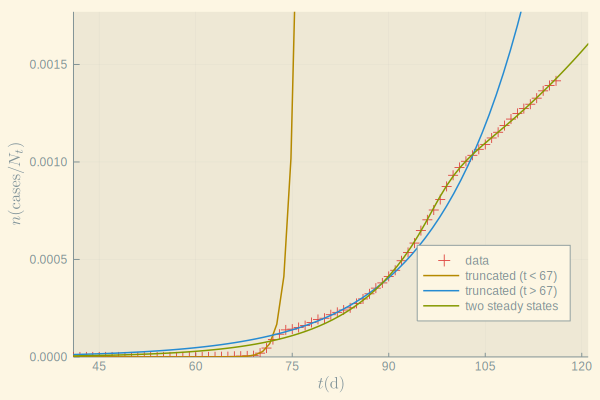

In [24]:
savefig("img/"*country_name*"_fits_converged_log.svg")

plot!( yscale = :auto, ylims = (nm,nM) )

In [25]:
# doubling times for each rate
round.( log(2) ./fit1.param[1:2:length(p1)]; sigdigits=3 )'

1×2 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 7.8  29.4

##### Estimate quality of fit

In [26]:
cov_mat = estimate_covar(fit1)
sigma = stderror(fit1)

margin_of_error = margin_error(fit1, 0.05)
confidence_inter = confidence_interval(fit1, 0.05)

# display the parameters
round.( fit1.param; sigdigits=3 )'

1×4 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 0.0889  15.8  0.0236  93.1

In [27]:
# estimate the margins of error
round.( sigma; sigdigits=3 )'

1×4 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 0.00168  0.155  0.000945  0.33

In [28]:
# estimate the margins of error
round.( margin_of_error; sigdigits=3 )'

1×4 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 0.00332  0.306  0.00187  0.653

In [29]:
# estimate the margins of error
confidence_inter

4-element Array{Tuple{Float64,Float64},1}:
 (0.0855899657169152, 0.09223043509235569)
 (15.48379839709331, 16.096676577371973)
 (0.0217341921850646, 0.025476946086308332)
 (92.39964019930555, 93.7063679420411)

In [30]:
# the covariance matrix estimate
round.( cov_mat; sigdigits=3 )

4×4 Array{Float64,2}:
  2.81e-6    0.000259   3.22e-7  -0.000382
  0.000259   0.0239     2.77e-5  -0.0335
  3.22e-7    2.77e-5    8.92e-7  -0.00021
 -0.000382  -0.0335    -0.00021   0.109